In [1]:
import numpy as np
from torchvision import models, transforms
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchvision import datasets
from torch.utils.data import DataLoader

from torch import nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [97]:
#install captum
'''!git clone https://github.com/pytorch/captum 

%cd captum

!git checkout "v0.2.0"

!pip3 install -e .

import sys
sys.path.append('/content/captum')

%cd ..'''

fatal: destination path 'captum' already exists and is not an empty directory.
/content/captum
HEAD is now at 4b2eb339 Adding matplotlib to Conda dependencies (#314)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/captum
  Attempting uninstall: captum
    Found existing installation: captum 0.2.0
    Can't uninstall 'captum'. No files were found to uninstall.
  Running setup.py develop for captum
/content


In [102]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/pytorch/captum.git
%cd captum
!pip install -e 

Cloning into 'captum'...
remote: Enumerating objects: 22231, done.
remote: Counting objects: 100% (883/883), done.
remote: Compressing objects: 100% (310/310), done.
remote: Total 22231 (delta 417), reused 776 (delta 361), pack-reused 21348
Receiving objects: 100% (22231/22231), 251.45 MiB | 21.49 MiB/s, done.
Resolving deltas: 100% (13655/13655), done.
Checking out files: 100% (404/404), done.
/content/captum

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument


In [3]:
# Import Captum
from captum.attr import Saliency
from captum.attr import visualization as vis
from captum.attr import (
	  GuidedBackprop,
	  Occlusion,
	  Saliency,
	  IntegratedGradients,
		GradientShap,
		Deconvolution,
		DeepLift,
		LRP,
		Lime
	)

In [4]:
# Download and prepare training and test data.
	
training_data = datasets.FashionMNIST(
	  root="data",
	  train=True,	
    download=True,	
    transform = transforms.Compose([transforms.ToTensor(),])	
)
	
test_data = datasets.FashionMNIST(	
    root="data",	
    train=False,	
    download=True,	
    transform=transforms.Compose([transforms.ToTensor(),])	
)
	
train_data_loader = DataLoader(training_data, batch_size=128)
	
test_data_loader = DataLoader(test_data, batch_size=128)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
#simple CNN Model for Fashion MNIST (with 2 convolutional layers)
class FashionNetwork(nn.Module):
	
    def __init__(self):
        super(FashionNetwork, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1)
        self.conv_2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5, stride = 1)
        self.lin1 = nn.Linear(in_features=12*4*4,out_features=120)
        self.lin2 = nn.Linear(in_features=120,out_features=40)
        self.lin3 = nn.Linear(in_features=40,out_features=10)   
	
    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)

        x = self.conv_2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = x.reshape(-1,12*4*4)
        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)
        x = F.relu(x)

        x = self.lin3(x)

        return x
	

In [6]:
#simple CNN Model for Fashion MNIST (with 2 convolutional layers)
class ImprovedFashionNetwork(nn.Module):
	
    def __init__(self):
        super(ImprovedFashionNetwork, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1)
        self.conv_2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5, stride = 1)
        self.drop = nn.Dropout(0.25)
        self.lin1 = nn.Linear(in_features=12*4*4,out_features=120)
        self.lin2 = nn.Linear(in_features=120,out_features=40)
        self.lin3 = nn.Linear(in_features=40,out_features=10)   
	
    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)

        x = self.conv_2(x)
        x = F.relu(x)
        x = self.drop(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = x.reshape(-1,12*4*4)
        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)
        x = F.relu(x)

        x = self.lin3(x)

        return x
	

In [7]:
#simple CNN Model for Fashion MNIST (with 2 convolutional layers)
class NewImprovedFashionNetwork(nn.Module):
	
    def __init__(self):
        super(NewImprovedFashionNetwork, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1)
        self.conv_2 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1)
        self.drop = nn.Dropout(0.25)
        self.lin1 = nn.Linear(in_features=16*24*24,out_features=10)   
	
    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.drop(x)

        x = self.conv_2(x)
        x = F.relu(x)
        x = self.drop(x)

        x = x.reshape(-1,16*24*24)
        x = self.lin1(x)


        return x
	

20

In [8]:
#simple CNN Model for Fashion MNIST (with 2 convolutional layers)
class DeeperFashionNetwork(nn.Module):
	
    def __init__(self):
        super(DeeperFashionNetwork, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1)
        self.conv_2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 3, stride = 1)
        self.conv_3 = nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, stride = 1)
        self.conv_4 = nn.Conv2d(in_channels = 24, out_channels = 32, kernel_size = 2, stride = 1)
        self.lin1 = nn.Linear(in_features=32*5*5,out_features=120)
        self.lin2 = nn.Linear(in_features=120,out_features=40)
        self.lin3 = nn.Linear(in_features=40,out_features=10)   
	
    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)

        x = self.conv_2(x)
        x = F.relu(x)

        x = self.conv_3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2)

        x = self.conv_4(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2)

        #flatten
        x = x.view(x.size(0), -1)  
        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)
        x = F.relu(x)

        x = self.lin3(x)

        return x
	

In [48]:
#train Fashion MNIST model
def train_loop(data_loader, model, loss_function, optimizer):
  for batch, (data, labels) in enumerate(data_loader):
    # Feed data through network and compute loss.
    prediction = model(data)
    loss = loss_function(prediction, labels)

    # Zero gradients.
    optimizer.zero_grad()
 
    # Perform backpropagation and accumulate gradients.
    loss.backward()

    # Update network parameters.
    optimizer.step()
	
 
	

In [49]:
def test_loop(data_loader, model, loss_function):
  n_samples = len(data_loader.dataset)
  n_batches = len(data_loader)
  
  loss, n_correct = 0, 0
		
  with torch.no_grad():
    for data, labels in data_loader:
      # Feed data through network and accumulate loss.
      prediction = model(data)

      this_loss = loss_function(prediction, labels).item()

      loss += this_loss
      
      n_correct += ((prediction.argmax(1) == labels).type(torch.float).sum().item())
	
 
	
  print(
      f"Test Accuracy: {n_correct / n_samples:.2%}, "
      f"Test Loss: {loss / n_batches:.4}"
  )

    
	
 

In [56]:
# Initialize network, loss function, and optimizer.
simple_cnn_model = FashionNetwork()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(simple_cnn_model.parameters(), lr=learning_rate)

In [72]:
deeper_model = DeeperFashionNetwork()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(deeper_model.parameters(), lr=learning_rate)

In [65]:
improved_model = ImprovedFashionNetwork()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(improved_model.parameters(), lr=learning_rate)

In [58]:
new_improved_model = NewImprovedFashionNetwork()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(new_improved_model.parameters(), lr=learning_rate)

In [54]:
from torchsummary import summary

summary(new_improved_model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
           Dropout-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           4,624
           Dropout-4           [-1, 16, 24, 24]               0
            Linear-5                   [-1, 10]          92,170
Total params: 97,114
Trainable params: 97,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 0.37
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [77]:
# Train the network.
n_epochs = 5
	
for t in range(n_epochs):
  print(f"Epoch {t + 1:02}", end=" ", flush=True) 
  train_loop(train_data_loader, deeper_model, loss_fn, optimizer)
  test_loop(test_data_loader, deeper_model, loss_fn)



Epoch 01 Test Accuracy: 90.07%, Test Loss: 0.3069
Epoch 02 Test Accuracy: 90.09%, Test Loss: 0.3131
Epoch 03 Test Accuracy: 90.21%, Test Loss: 0.3094
Epoch 04 Test Accuracy: 90.36%, Test Loss: 0.3234
Epoch 05 Test Accuracy: 89.97%, Test Loss: 0.3284


In [ ]:
# https://towardsdatascience.com/practical-transfer-learning-with-pytorch-8344e5c82f59
#Cite!
class TransferFeatures(nn.Module):
    def __init__(self, original_model, classifier, model_name):
        super(TransferFeatures, self).__init__()

        self.features = original_model.features
        self.classifier = classifier
        self.modelName = model_name

        # Freeze those weights
        for p in self.features.parameters():
            p.requires_grad = False

    def forward(self, x):
        f = self.features(x)
        # flatten network
        f = f.view(f.size(0), np.prod(f.shape[1:]))
        y = self.classifier(f)
        return y

In [ ]:
#https://towardsdatascience.com/practical-transfer-learning-with-pytorch-8344e5c82f59
#Cite!

#use pretrained model
#transfer learning to Fashion MNIST dataset

#import pretrained model (architecture + training)
alex = models.alexnet(pretrained=True)

fashion = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 10),
)

pretrained_model = TransferFeatures(alex, fashion, 'transfer')



#change data to be usable with VGG16

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
# Download and prepare training and test data.

#Make RGB and size of AlexNet
def transform_RGB(img):
    img = img.resize((224, 224)).convert('RGB')
    tensor = ToTensor()(img)
    return tensor

training_data_RGB = datasets.FashionMNIST(
	  root="data",
	  train=True,	
    download=True,	
    transform = transform_RGB
)
	
test_data_RGB = datasets.FashionMNIST(	
    root="data",	
    train=False,	
    download=True,	
    transform=transform_RGB
)
	
train_data_loader_RGB = DataLoader(training_data_RGB, batch_size=4)
	
test_data_loader_RGB = DataLoader(test_data_RGB, batch_size=4)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
# Initialize network, loss function, and optimizer.
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=learning_rate)

In [ ]:
n_epochs = 2
for t in range(n_epochs):
  print(f"Epoch {t + 1:02}", end=" ", flush=True) 
  train_loop(train_data_loader_RGB, pretrained_model, loss_fn, optimizer)
  test_loop(test_data_loader_RGB, pretrained_model, loss_fn)

Epoch 01 Test Accuracy: 81.35%, Test Loss: 0.6193
Epoch 02 Test Accuracy: 82.46%, Test Loss: 0.6763


In [81]:
#NEW TRANSFER LEARNING
#https://github.com/Arkonil/FashionMNIST-VGG16-Pytorch/blob/main/FashionMNIST_VGG_transfer_learning_pytorch.ipynb
from torchvision.models import vgg19
model = vgg19(pretrained=True)

# Keeping gradients for pretrained weights fixed
for param in model.parameters():
    param.requires_grad = False
    
# Adding custom layer for new number of outputs
n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
    nn.Softmax(dim=1)
)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [82]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [84]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize(size=224),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

training_data_RGB = datasets.FashionMNIST(
	  root="data",
	  train=True,	
    download=True,	
    transform = transform
)
	
test_data_RGB = datasets.FashionMNIST(	
    root="data",	
    train=False,	
    download=True,	
    transform=transform
)
	
train_data_loader_RGB = DataLoader(training_data_RGB, batch_size=32)
	
test_data_loader_RGB = DataLoader(test_data_RGB, batch_size=32)

In [85]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the network.
n_epochs = 3
	
for t in range(n_epochs):
  print(f"Epoch {t + 1:02}", end=" ", flush=True) 
  train_loop(train_data_loader_RGB, model, loss_fn, optimizer)
  test_loop(test_data_loader_RGB, model, loss_fn)


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
model_save_name = 'new_improved_model.pt'
#model_save_name = 'simple_cnn_model.pt'
#model_save_name = 'pretrained_model.pt'
path = F"/content/drive/My Drive/{model_save_name}" 


In [89]:
torch.save(model.state_dict(), path)

In [12]:
simple_cnn_model = NewImprovedFashionNetwork()
simple_cnn_model.load_state_dict(torch.load(path))
simple_cnn_model.eval()

NewImprovedFashionNetwork(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (drop): Dropout(p=0.25, inplace=False)
  (lin1): Linear(in_features=9216, out_features=10, bias=True)
)

In [8]:
simple_cnn_model = FashionNetwork()
simple_cnn_model.load_state_dict(torch.load(path))
simple_cnn_model.eval()

FashionNetwork(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (lin1): Linear(in_features=192, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=40, bias=True)
  (lin3): Linear(in_features=40, out_features=10, bias=True)
)

In [9]:
#confusion matrix
#from: https://coderzcolumn.com/tutorials/artificial-intelligence/captum-for-pytorch-image-classification-networks
def MakePredictions(model, loader):
    preds, Y_shuffled = [], []
    for X_batch, Y_batch in loader:
        preds.append(model(X_batch))
        Y_shuffled.append(Y_batch)

    preds = torch.cat(preds).argmax(axis=-1)
    Y_shuffled = torch.cat(Y_shuffled)
    return Y_shuffled, preds

label_names = ['T-shirtTop', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankleboot']



Y_test_shuffled, test_preds = MakePredictions(simple_cnn_model, test_data_loader)

print("Test  Accuracy : {:.3f}".format(accuracy_score(Y_test_shuffled, test_preds)))
print("\nTest Data Classification Report : ")
print(classification_report(Y_test_shuffled, test_preds, target_names=label_names))
print("\nTest Data Confusion Matrix : ")
print(confusion_matrix(Y_test_shuffled, test_preds))

Test  Accuracy : 0.885

Test Data Classification Report : 
              precision    recall  f1-score   support

  T-shirtTop       0.79      0.86      0.82      1000
     Trouser       0.97      0.98      0.98      1000
    Pullover       0.90      0.75      0.82      1000
       Dress       0.89      0.89      0.89      1000
        Coat       0.83      0.79      0.81      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.66      0.73      0.69      1000
     Sneaker       0.92      0.97      0.95      1000
         Bag       0.98      0.97      0.97      1000
   Ankleboot       0.97      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Test Data Confusion Matrix : 
[[858   2   4  15   1   2 110   0   8   0]
 [  6 979   0  12   1   0   1   0   1   0]
 [ 30   3 749   7  94   0 114   0   3   0]
 [ 36  15   1 892  16 

In [ ]:
pretrained_model = TransferFeatures(alex, fashion, 'transfer')
pretrained_model.load_state_dict(torch.load(path))
pretrained_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


TransferFeatures(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropou

In [13]:
model = simple_cnn_model
d = iter(test_data_loader)
images, labels = d.next()

In [ ]:
model = pretrained_model
d = iter(test_data_loader_RGB)
images, labels = d.next()

In [ ]:
images.shape

torch.Size([4, 3, 224, 224])

In [ ]:
d1 = enumerate(test_data_loader_RGB, 0)

In [ ]:
images[2].shape

torch.Size([3, 224, 224])

In [14]:
# Prepare input.
tensor = images[2]

In [ ]:
images.shape

torch.Size([4, 3, 224, 224])

In [13]:
tensor = images[2]

In [ ]:
prediction = 1

In [ ]:
y_trues = []
y_preds = []
torch.multiprocessing.set_sharing_strategy('file_system')
for i, data in enumerate(test_data_loader_RGB, 0):
    inputs, labels = data
    y_trues.append(int(labels[0]))
    print(inputs.shape)
    out = model(inputs)
    # get the most probable label
    _, index = torch.topk(out, 1)
    y_preds.append(int(index[0]))

In [15]:
# Feed input through network.
prediction = model(tensor).argmax().item()
print(prediction)
print(labels[2].item())

1
1


In [16]:
# Decode prediction.
label_names = ['T-shirtTop', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankleboot']


In [ ]:
label_names[prediction]

'Trouser'

84

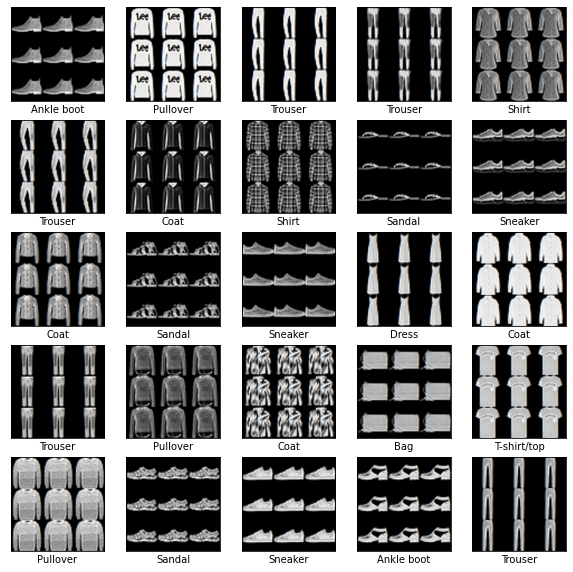

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data_RGB[i][0].reshape(224,224,3))
    plt.xlabel(label_names[test_data_RGB[i][1]])
plt.show()

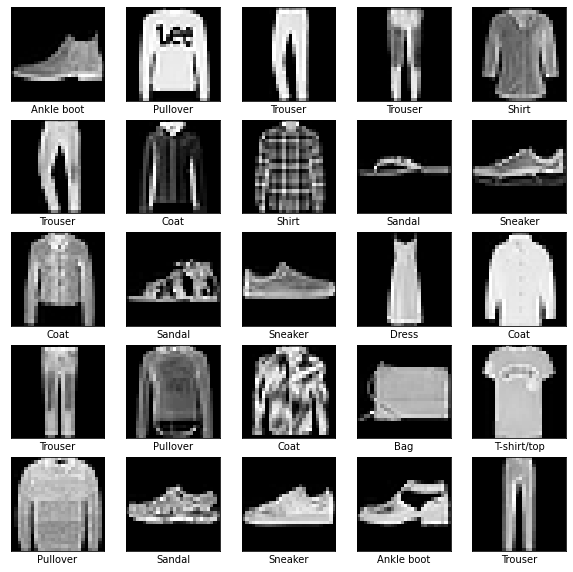

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.gray()
    plt.imshow(np.stack((test_data[i][0].reshape(28,28), test_data[i][0].reshape(28,28),test_data[i][0].reshape(28,28)), axis=2), cmap="gray")
    plt.xlabel(label_names[test_data[i][1]])
plt.show()

In [ ]:
print(label_names[prediction])

Ankle boot


In [ ]:
tensor.size()

torch.Size([1, 28, 28])

In [ ]:
#PRETRAINED
org_image=np.transpose(test_data_RGB[2][0].numpy(), (1,2,0))

In [ ]:
org_image.shape

(224, 224, 3)

In [ ]:
#FOR PRETRAINED MODEL
# Compute attribution.
saliency = Saliency(model)
attribution = saliency.attribute(tensor, target=prediction).cpu().numpy().squeeze()

	
# Visualize.
figure, _ = vis.visualize_image_attr(attribution.reshape(224,224,3),
                                     #original_image=np.stack((test_data[0][0].reshape(28,28),np.zeros((28,28)), np.zeros((28,28))), axis=2),
                                     #original_image= np.transpose(test_data[0][0].numpy(), (1,2,0)),
                                     original_image= org_image,
                                     method="blended_heat_map",
                                     use_pyplot=False)
figure.savefig('saliency_fashion.png', bbox_inches="tight", pad_inches=0)

In [ ]:
im = 8
tensor = images[im]

# Feed input through network.
prediction = model(tensor).argmax().item()
print(prediction)
print(labels[im].item())


org_image=np.transpose(test_data[im][0].numpy(), (1,2,0))

# Compute attribution.
saliency = Saliency(model)
attribution = saliency.attribute(tensor, target=prediction).cpu().numpy().squeeze()

	
# Visualize.
figure, _ = vis.visualize_image_attr(attribution.reshape(28,28,1),
                                     #original_image=np.stack((test_data[0][0].reshape(28,28),np.zeros((28,28)), np.zeros((28,28))), axis=2),
                                     #original_image= np.transpose(test_data[0][0].numpy(), (1,2,0)),
                                     original_image= org_image,
                                     method="blended_heat_map",
                                     use_pyplot=False)
figure.savefig(f'saliency_{label_names[prediction]}_{prediction}.png', bbox_inches="tight", pad_inches=0)


5
5


/content/captum/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [ ]:
im = 8
tensor = images[im]

# Feed input through network.
prediction = model(tensor).argmax().item()
print(prediction)
print(labels[im].item())


org_image=np.transpose(test_data[im][0].numpy(), (1,2,0))

# Compute attribution.
ig = IntegratedGradients(model)
attribution = ig.attribute(tensor, target=prediction).cpu().numpy().squeeze()

	
# Visualize.
figure, _ = vis.visualize_image_attr(attribution.reshape(28,28,1),
                                     #original_image=np.stack((test_data[0][0].reshape(28,28),np.zeros((28,28)), np.zeros((28,28))), axis=2),
                                     #original_image= np.transpose(test_data[0][0].numpy(), (1,2,0)),
                                     original_image= org_image, show_colorbar=True,
                                     cmap="Oranges", title="Integrated Gradients",
                                     #method="blended_heat_map",
                                     #use_pyplot=False
                                     )
figure.savefig(f'saliency_{label_names[prediction]}_{prediction}.png', bbox_inches="tight", pad_inches=0)


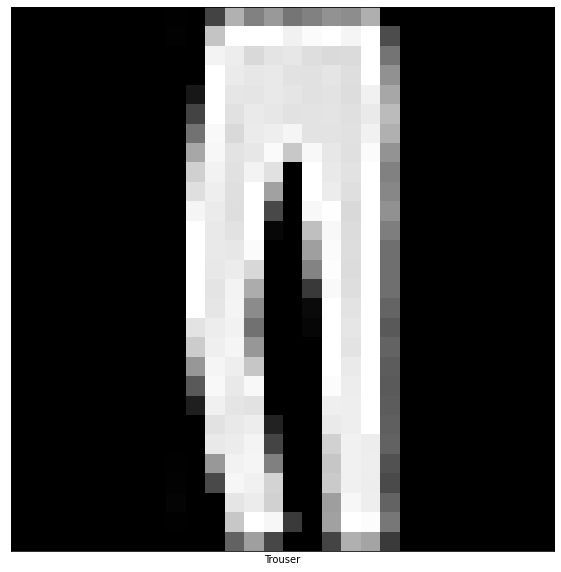

In [ ]:
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.gray()
plt.imshow(np.stack((test_data[2][0].reshape(28,28), test_data[2][0].reshape(28,28),test_data[2][0].reshape(28,28)), axis=2), cmap="gray")
plt.xlabel(label_names[test_data[2][1]])
plt.show()

In [ ]:
attribution.shape

(28, 28)

In [ ]:
tensor.shape

torch.Size([1, 28, 28])

In [25]:
im = 8
tensor = images[im]

# Feed input through network.
prediction = model(tensor).argmax().item()
print(prediction)
print(labels[im].item())


org_image=np.transpose(test_data[im][0].numpy(), (1,2,0))

methods = [
	  (Saliency(model), {}),
    #(LRP(model), {}),
	  #(GuidedBackprop(model), {}),
	  #(IntegratedGradients(model), {}),
    #(GradientShap(model), {"baselines"=torch.zeros_like(X[:1])}),
	  #(Occlusion(model),{"sliding_window_shapes": (2,2), "strides": (2,2),},),
	]

 
for (method, params) in methods:
  #figure, axes = plt.subplots(2, 2, figsize=(2 * 3.8, 2 * 3.8))
  attribution = (method.attribute(tensor, target=prediction, 
                                  **params).cpu().numpy().squeeze())
	
  figure, _ = vis.visualize_image_attr(attribution.reshape(28,28,1),original_image=org_image,
                           method="blended_heat_map",sign="positive",show_colorbar=True,
                           use_pyplot=False,)
	
  #axis.set_title(type(method).__name__)
	
 
  #plt.tight_layout()
	
  figure.savefig("lrp.png", bbox_inches="tight")

5
5


In [22]:
im = 8
tensor = images[im]

# Feed input through network.
prediction = model(tensor).argmax().item()
print(prediction)
print(labels[im].item())


org_image=np.transpose(test_data[im][0].numpy(), (1,2,0))

methods = [
	  #(Saliency(model), {}),
    (LRP(model), {}),
	  #(GuidedBackprop(model), {}),
	  #(IntegratedGradients(model), {}),
    #(GradientShap(model), {"baselines"=torch.zeros_like(X[:1])}),
	  #(Occlusion(model),{"sliding_window_shapes": (2,2), "strides": (2,2),},),
	]

 
for (method, params) in methods:
  #figure, axes = plt.subplots(2, 2, figsize=(2 * 3.8, 2 * 3.8))
  attribution = (method.attribute(tensor, target=prediction, 
                                  **params).cpu().detach().numpy().squeeze())
	
  figure, _ = vis.visualize_image_attr(attribution.reshape(28,28,1),original_image=org_image,
                           method="blended_heat_map",sign="positive",show_colorbar=True,
                           use_pyplot=False,)
	
  #axis.set_title(type(method).__name__)
	
 
  #plt.tight_layout()
	
  figure.savefig("lrp.png", bbox_inches="tight")

5
5


/content/captum/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [26]:
predictions = model(tensor).squeeze()
values = torch.softmax(predictions, 0)
sorted_values, sorted_idx = torch.topk(values, 10)
	
guided = GuidedBackprop(model)

In [24]:
values

tensor([1.0778e-04, 6.6301e-09, 2.9695e-08, 2.3470e-08, 9.9462e-07, 9.9986e-01,
        1.1133e-07, 1.6109e-05, 1.0238e-05, 2.9560e-06],
       grad_fn=<SoftmaxBackward0>)

In [18]:
sorted_values.cpu().squeeze()

tensor([1.0000e+00, 3.4199e-08, 9.5866e-10, 1.0056e-10, 6.6007e-12, 3.8698e-14,
        2.2200e-14, 3.8455e-19, 2.3389e-20, 1.3547e-29],
       grad_fn=<SqueezeBackward0>)

In [27]:
best_worst_class_values = [sorted_values[i] for i in [0,1,-1]]
best_worst_class_idx = [sorted_idx[i] for i in [0,1,-1]]

In [ ]:
best_worst_class_idx

[tensor(1), tensor(3), tensor(7)]

In [28]:
im = 8
tensor = images[im]

# Feed input through network.
prediction = model(tensor).argmax().item()
print(prediction)
print(labels[im].item())


org_image=np.transpose(test_data[im][0].numpy(), (1,2,0))

5
5


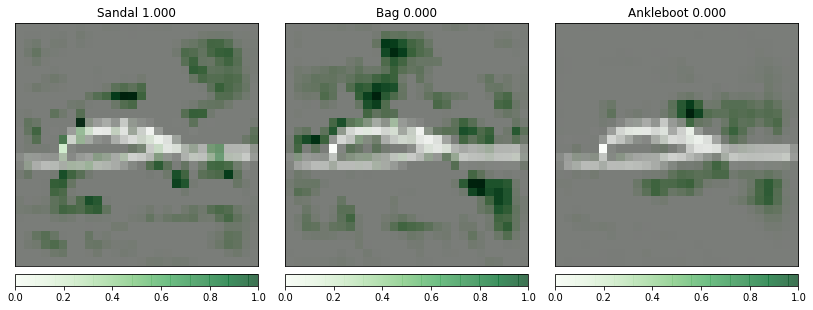

In [30]:
figure, axes = plt.subplots(1, 3, figsize=(3 * 3.8, 2 * 3.8))
	
for axis, i, v in zip(axes.flatten(),best_worst_class_idx,best_worst_class_values):
  attribution = (guided.attribute(tensor, target=int(i)).numpy().squeeze())
  #vis.visualize_image_attr(None, org_image, method="original_image")
 
  vis.visualize_image_attr(attribution.reshape(28,28,1),original_image=org_image,
                           #method="heat_map", 
                           method="blended_heat_map",sign="positive",plt_fig_axis=(figure, axis),
                           show_colorbar=True, 
                           use_pyplot=False)
	
  axis.set_title(label_names[i.item()] + f" {v:0.3f}")
	
plt.tight_layout()
	
figure.savefig("topk.svg", bbox_inches="tight")